In [1]:
import datetime as dt
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
import sys
sys.path.insert(0, '../../../purity-monitor/')
sys.path.insert(0, '../../WaveformAnalysis/')

In [4]:
import Dataset as Dataset
import StandMonitor as Monitor
import PlotFunctions as Plt
import Waveform as Waveform
import SiPM as SiPM

In [5]:
import importlib
importlib.reload(Dataset)
importlib.reload(Monitor)
importlib.reload(Plt)
importlib.reload(SiPM)

<module 'SiPM' from '../../../purity-monitor/SiPM.py'>

In [6]:
from scipy.special import erfc
from scipy.optimize import curve_fit
def func(x,V0,sigma,tau,mu):
    return V0 * np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) * erfc(1/np.sqrt(2) * (sigma/tau - (x-mu)/sigma))

In [7]:
D0 = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211110/', 
                    Selection='SiPM_31V_SourceFar_0*.h5')
D0.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

for File in D0.Files:
    D0.ImportDataFromHDF5(File, D0.Ch)

In [8]:
Amp = D0.Ch[1].Amp[0]-np.mean(D0.Ch[1].Amp[0])
Times = np.arange(D0.Ch[1].Time[0],D0.Ch[1].Time[-1],100)

[398 843]
nr of samples:  117928
total time in us:  100002.09599999999
time between samples in us:  0.847992809171698
sampling rate in MHz:  1.1792552828092724
[  177.04076264     3.36433678    25.72935878 -3265.38133586]
0 [ 1.54120668e+02  2.76190656e+00  3.47564251e+01 -3.26596806e+03]
1 [ 3.13016217e+01  2.20746250e+00  3.35426680e+01 -2.88750533e+03]


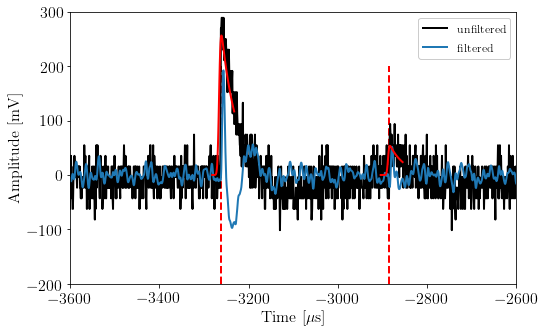

In [30]:
start = -37600
count = 34
offset = count*1000
cut = np.where((D0.Ch[1].Time > start+offset) & (D0.Ch[1].Time < start+offset+1000))[0]

from scipy.signal import find_peaks


avg_time, avg_wvf = D0.get_averaged_waveform(D0.Ch[1].Time[cut], Amp[cut], avg=10)


max_val = np.max(avg_wvf)
max_pos_cut = np.where(avg_wvf == np.max(avg_wvf))[0][0]
max_pos = D0.Ch[1].Time[cut][max_pos_cut]

peaks,pdict = find_peaks(avg_wvf, height=20, width=15, distance=50)
print(peaks)
print('nr of samples: ',len(D0.Ch[1].Time))
print('total time in us: ', D0.Ch[1].Time[-1]- D0.Ch[1].Time[0])
print('time between samples in us: ', (D0.Ch[1].Time[-1]- D0.Ch[1].Time[0])/len(D0.Ch[1].Time))
print('sampling rate in MHz: ',1/((D0.Ch[1].Time[-1]- D0.Ch[1].Time[0])/len(D0.Ch[1].Time)))


y = D0.get_filtered_waveform(D0.Ch[1].Time, Amp, lowfreq=10000, highfreq=100000, type='band', order=3)


# popt, pcov = curve_fit(func, D0.Ch[1].Time[cut], y[cut], p0=[max_val, 10, 50, max_pos], maxfev=10000)
# print(popt[0])
popt, pcov = curve_fit(func, avg_time, avg_wvf, p0=[max_val, 10, 50, max_pos], maxfev=10000)
print(popt)


plt.figure(figsize=(8,5))
for ii,p in enumerate(peaks): 
    plt.vlines(x=D0.Ch[1].Time[cut][p], ymin=-200,ymax=200, color='r', ls='--')
    peak_pos = D0.Ch[1].Time[cut][p]
    peak_height = pdict['peak_heights'][ii]
    fit_cut = np.where((D0.Ch[1].Time[cut]>D0.Ch[1].Time[cut][p]-20) 
                       & (D0.Ch[1].Time[cut]<D0.Ch[1].Time[cut][p]+30))
    popt, pcov = curve_fit(func, avg_time[fit_cut], avg_wvf[fit_cut], 
                           p0=[peak_height, 1, 40, peak_pos], 
                           maxfev=10000)
    plt.plot(D0.Ch[1].Time[cut][fit_cut], func(D0.Ch[1].Time[cut][fit_cut], *popt), color='r', zorder=10)
    print(ii, popt)



plt.xlim(start+offset,start+offset+1000)
plt.xlabel('Time [$\mu$s]')
plt.ylabel('Amplitude [mV]')

plt.plot(D0.Ch[1].Time[cut], Amp[cut], label='unfiltered', color='k')
plt.plot(D0.Ch[1].Time[cut], y[cut], label='filtered')
# plt.plot(avg_time, avg_wvf, label='Moving average')

# plt.plot(D0.Ch[1].Time[cut], func(D0.Ch[1].Time[cut], *popt))
plt.legend(loc='upper right')
plt.show()

In [10]:
# for ii,x in enumerate(Times):
#     if ii > 1000: 
#         break
#     plt.figure()
#     cut = np.where((D0.Ch[1].Time > x) & (D0.Ch[1].Time < x+1000))[0]
#     plt.plot(D0.Ch[1].Time[cut], Amp[cut])
    
#     max_val = np.max(Amp[cut])
#     max_pos_cut = np.where(Amp[cut] == np.max(Amp[cut]))[0][0]
#     max_pos = D0.Ch[1].Time[cut][max_pos_cut]
    
    
#     popt, pcov = curve_fit(func, D0.Ch[1].Time[cut], Amp[cut], p0=[max_val, 10, 50, max_pos], maxfev=10000)
#     plt.plot(D0.Ch[1].Time[cut], func(D0.Ch[1].Time[cut], *popt), color='r')
#     print(max_val, max_pos, popt, np.max(func(D0.Ch[1].Time[cut], *popt)))
#     plt.show()
# # popt, pcov = curve_fit(func, D0.Ch[1].Time[cut], Amp[cut], p0=[np.max(Amp[cut]), 1, 100, 4])
# # print(popt)

# # plt.plot(D0.Ch[1].Time[cut], func(D0.Ch[1].Time[cut], *popt), color='r')
# # print(np.max(func(D0.Ch[1].Time[cut], *popt)))
